In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta, date, time
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import ssl
import urllib
import json
from sklearn.cluster import KMeans
from haversine import haversine
import scipy.cluster.hierarchy as shc
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg')
sns.set_theme()

---

# Import the data

Trip data (already formatted and outliers have been removed, please refer to Preprocessing.ipynb)

In [2]:
df_bonn_original = pd.read_pickle("data/df_bonn.pickle")
df_essen_original = pd.read_pickle("data/df_essen.pickle")

In [3]:
# Create a weekday dictonary to show the weekday names in the plots
weekdays = {
    0: "Monday",
    1: "Tuesday",
    2: "Wednesday",
    3: "Thursday",
    4: "Friday",
    5: "Saturday",
    6: "Sunday"
}

---

# Clustering

In [4]:
# Calculate the 95% quantile to improve the clustering results
# Bonn
df_bonn = df_bonn_original[(df_bonn_original.trip_duration < df_bonn_original.trip_duration.quantile(0.95))]
df_bonn = df_bonn.reset_index(drop = True)

# Essen
df_essen = df_essen_original[(df_essen_original.trip_duration < df_essen_original.trip_duration.quantile(0.95))]
df_essen = df_essen.reset_index(drop = True)

## Daytime / Trip_duration Clustering

### Bonn - Complete / Not seasonal

At first we have to extract trip's daytimes and tripdurations

In [5]:
df_bonn_clustering = pd.DataFrame(columns = ['time', 'trip_duration'])
df_bonn_clustering['time'] = df_bonn['timestamp'].dt.hour
df_bonn_clustering['trip_duration'] = df_bonn['trip_duration']
df_bonn_clustering['trip_duration'] = df_bonn_clustering['trip_duration'] / np.timedelta64(1, 'm')

#Normalize Data
mms_bonn = StandardScaler()
mms_bonn.fit(df_bonn_clustering)
df_bonn_normalized =  mms_bonn.transform(df_bonn_clustering)

Now the number of clusters has to be determined

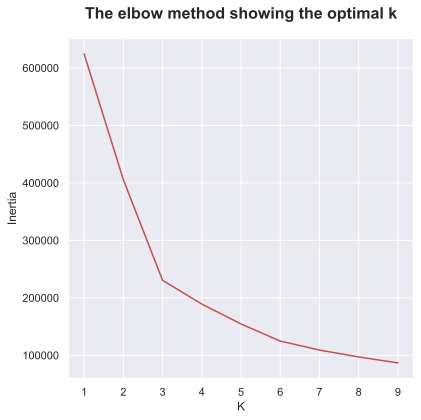

In [6]:
distortions_bonn = []
K = range(1,10)

for k in K:
    kmeansModel_bonn = KMeans(n_clusters=k, init='k-means++', random_state=42)
    kmeansModel_bonn.fit(df_bonn_normalized)
    distortions_bonn.append(kmeansModel_bonn.inertia_)
    
fig = plt.figure(figsize=(6,6))
ax = sns.lineplot(x = K, y = distortions_bonn, color= 'C3')
ax.set_title('The elbow method showing the optimal k', fontsize=16, fontweight='bold',pad=20)
ax.set(xlabel ='K', ylabel='Inertia')
fig.tight_layout()
fig.savefig('elbow_bonn.pdf')

In [7]:
# Six Clusters should fit
kmeansModel_bonn = KMeans(n_clusters = 6, init='k-means++', random_state=42)
kmeansModel_bonn = kmeansModel_bonn.fit(df_bonn_normalized)

df_bonn_clustering['labels'] = kmeansModel_bonn.labels_

n_cluster_bonn = np.bincount(df_bonn_clustering['labels'])
for i in n_cluster_bonn:
    print("Cluster "+ str(np.where(n_cluster_bonn == i)[0]) + ': '  + str(i))

Cluster [0]: 68997
Cluster [1]: 54248
Cluster [2]: 80141
Cluster [3]: 27255
Cluster [4]: 25040
Cluster [5]: 56436


Text(0, 0.5, 'Time (h)')

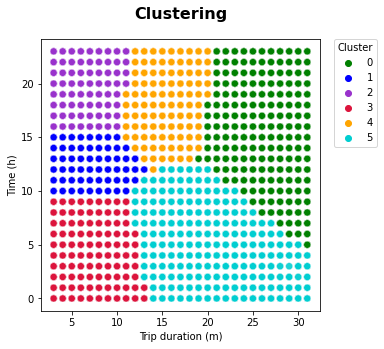

In [64]:
fig = plt.figure(figsize=(5,5))
ax = sns.scatterplot(data = df_bonn_clustering, x = "trip_duration", y = "time", hue='labels', s=50, alpha=0.5, palette = ['green','blue','darkorchid','crimson','orange','darkturquoise'])
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., title='Cluster')
ax.set_title('Clustering', fontsize=16, fontweight='bold',pad=20)
ax.set_xlabel('Trip duration (m)')
ax.set_ylabel('Time (h)')
fig.tight_layout()
fig.savefig('clustering_bonn.pdf')

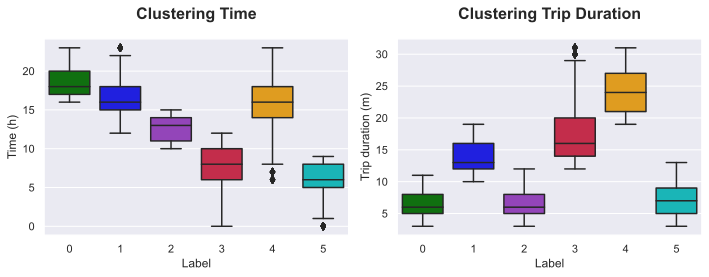

In [12]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(10,4))
sns.boxplot(x="labels", y="time", ax=ax1, data=df_bonn_clustering, palette=['green','blue','darkorchid','crimson','orange','darkturquoise'])
ax1.set_title('Clustering Time', fontsize=16, fontweight='bold',pad=20)
ax1.set_xlabel('Label')
ax1.set_ylabel('Time (h)')
sns.boxplot(x="labels", y="trip_duration", ax=ax2, data=df_bonn_clustering, palette=['green','blue','darkorchid','crimson','orange','darkturquoise'])
ax2.set_title('Clustering Trip Duration', fontsize=16, fontweight='bold',pad=20)
ax2.set_xlabel('Label')
ax2.set_ylabel('Trip duration (m)')
fig.tight_layout()
fig.savefig('cluster_time_trip_bonn.pdf')

### Bonn - Seasonal

Time / trip duration clustering - Seasonal view

In [16]:
df_bonn_seasonal_clustering = pd.DataFrame(columns = ['time', 'trip_duration','season'])
df_bonn_seasonal_clustering['time'] = df_bonn['timestamp'].dt.hour
df_bonn_seasonal_clustering['trip_duration'] = df_bonn['trip_duration']
df_bonn_seasonal_clustering['trip_duration'] = df_bonn_seasonal_clustering['trip_duration'] / np.timedelta64(1, 'm')
df_bonn_seasonal_clustering['season'] = df_bonn['season']

#df_bonn_winter = df_bonn_seasonal_clustering
df_bonn_winter = pd.DataFrame(columns = ['time', 'trip_duration'])
df_bonn_winter['time'] = df_bonn['timestamp'].dt.hour[(df_bonn.timestamp.dt.date < date(2019, 3, 1))]
df_bonn_winter['trip_duration'] = df_bonn['trip_duration'][(df_bonn.timestamp.dt.date < date(2019, 3, 1))]
df_bonn_winter['trip_duration'] = df_bonn_winter['trip_duration'] / np.timedelta64(1, 'm')

df_bonn_spring = pd.DataFrame(columns = ['time', 'trip_duration'])
df_bonn_spring['time'] = df_bonn['timestamp'].dt.hour[(df_bonn.timestamp.dt.date >= date(2019, 3, 1)) & (df_bonn.timestamp.dt.date < date(2019, 6, 1))]
df_bonn_spring['trip_duration'] = df_bonn['trip_duration'][(df_bonn.timestamp.dt.date >= date(2019, 3, 1)) & (df_bonn.timestamp.dt.date < date(2019, 6, 1))]
df_bonn_spring['trip_duration'] = df_bonn_spring['trip_duration'] / np.timedelta64(1, 'm')

df_bonn_summer = pd.DataFrame(columns = ['time', 'trip_duration'])
df_bonn_summer['time'] = df_bonn['timestamp'].dt.hour[(df_bonn.timestamp.dt.date >= date(2019, 6, 1))]
df_bonn_summer['trip_duration'] = df_bonn['trip_duration'][(df_bonn.timestamp.dt.date >= date(2019, 6, 1))]
df_bonn_summer['trip_duration'] = df_bonn_summer['trip_duration'] / np.timedelta64(1, 'm')

#Normalize Data
standard_bonn_winter = StandardScaler()
standard_bonn_spring = StandardScaler()
standard_bonn_summer = StandardScaler()
standard_bonn_winter.fit(df_bonn_winter)
standard_bonn_spring.fit(df_bonn_spring)
standard_bonn_summer.fit(df_bonn_summer)
df_bonn_winter_normalized = standard_bonn_winter.transform(df_bonn_winter)
df_bonn_spring_normalized = standard_bonn_spring.transform(df_bonn_spring)
df_bonn_summer_normalized = standard_bonn_summer.transform(df_bonn_summer)

Text(0, 0.5, 'Inertia')

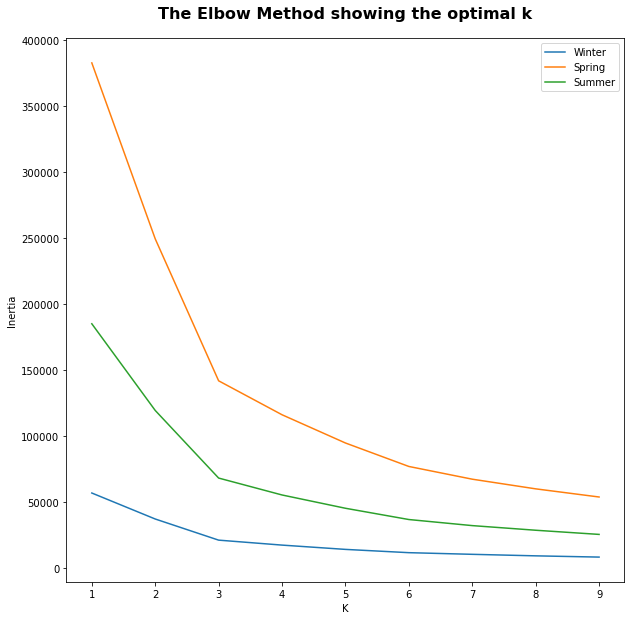

In [71]:
distortions_bonn_winter = []
distortions_bonn_spring = []
distortions_bonn_summer = []
K = range(1,10)

for k in K:
    kmeansModel_bonn_winter = KMeans(n_clusters=k, init='k-means++')
    kmeansModel_bonn_spring = KMeans(n_clusters=k, init='k-means++')
    kmeansModel_bonn_summer = KMeans(n_clusters=k, init='k-means++')
    
    kmeansModel_bonn_winter.fit(df_bonn_winter_normalized)
    kmeansModel_bonn_spring.fit(df_bonn_spring_normalized)
    kmeansModel_bonn_summer.fit(df_bonn_summer_normalized)
    
    
    distortions_bonn_winter.append(kmeansModel_bonn_winter.inertia_)
    distortions_bonn_spring.append(kmeansModel_bonn_spring.inertia_)
    distortions_bonn_summer.append(kmeansModel_bonn_summer.inertia_)
    

fig, axes = plt.subplots(1,1, sharex = True, figsize = (10,10))   
figure2 = sns.lineplot(x = K, y = distortions_bonn_winter, legend='brief', label='Winter')
sns.lineplot(x = K, y = distortions_bonn_spring, legend='brief', label='Spring')
sns.lineplot(x = K, y = distortions_bonn_summer, legend='brief', label='Summer')
figure2.set_title('The Elbow Method showing the optimal k', fontsize=16, fontweight='bold',pad=20)
#fig.suptitle('The Elbow Method showing the optimal k')
plt.xlabel('K')
plt.ylabel('Inertia')

In [18]:
# Six Clusters should fit
kmeansModel_bonn_winter = KMeans(n_clusters = 6, init='k-means++')
kmeansModel_bonn_spring = KMeans(n_clusters = 6, init='k-means++')
kmeansModel_bonn_summer = KMeans(n_clusters = 6, init='k-means++')

kmeansModel_bonn_winter = kmeansModel_bonn_winter.fit(df_bonn_winter_normalized)
kmeansModel_bonn_spring = kmeansModel_bonn_spring.fit(df_bonn_spring_normalized)
kmeansModel_bonn_summer = kmeansModel_bonn_summer.fit(df_bonn_summer_normalized)


df_bonn_winter['labels'] = kmeansModel_bonn_winter.labels_
df_bonn_spring['labels'] = kmeansModel_bonn_spring.labels_
df_bonn_summer['labels'] = kmeansModel_bonn_summer.labels_

#Counts number of data in each cluster
n_cluster_bonn_winter = np.bincount(df_bonn_winter['labels'])
n_cluster_bonn_spring = np.bincount(df_bonn_spring['labels'])
n_cluster_bonn_summer = np.bincount(df_bonn_summer['labels'])

Text(0, 0.5, 'Time')

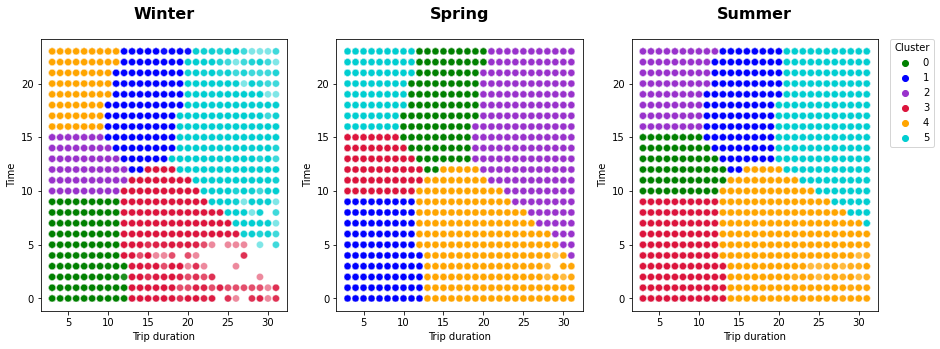

In [74]:
fig, axes = plt.subplots(1,3, sharex = True, figsize = (15,5))
sns.scatterplot(ax = axes[0], data = df_bonn_winter, x = "trip_duration", y = "time", hue='labels', s=50, alpha=0.5, palette = ['green','blue','darkorchid','crimson','orange','darkturquoise'])
axes[0].set_title('Winter', fontsize=16, fontweight='bold',pad=20)
axes[0].get_legend().remove()
axes[0].set_xlabel('Trip duration')
axes[0].set_ylabel('Time')
sns.scatterplot(ax = axes[1], data = df_bonn_spring, x = "trip_duration", y = "time", hue='labels', s=50, alpha=0.5, palette = ['green','blue','darkorchid','crimson','orange','darkturquoise'])
axes[1].set_title('Spring', fontsize=16, fontweight='bold',pad=20)
axes[1].get_legend().remove()
axes[1].set_xlabel('Trip duration')
axes[1].set_ylabel('Time')
sns.scatterplot(ax = axes[2], data = df_bonn_summer, x = "trip_duration", y = "time", hue='labels', s=50, alpha=0.5, palette = ['green','blue','darkorchid','crimson','orange','darkturquoise'])
axes[2].set_title('Summer', fontsize=16, fontweight='bold',pad=20)
axes[2].legend(bbox_to_anchor=(1.05,1),loc=2,borderaxespad=0.,title='Cluster')
axes[2].set_xlabel('Trip duration')
axes[2].set_ylabel('Time')

Text(0, 0.5, 'Trip duration')

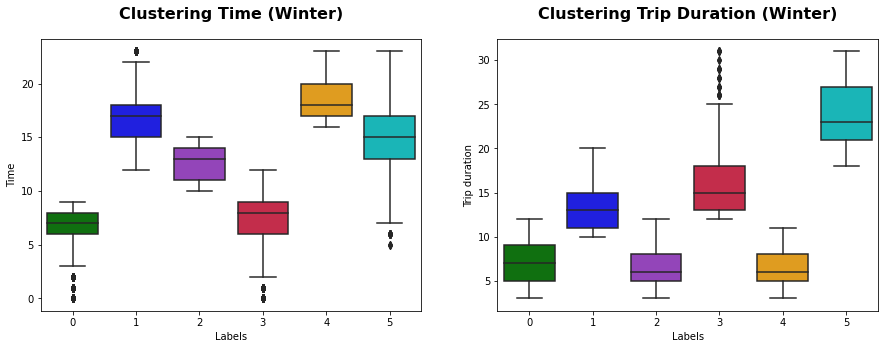

In [77]:
fig, axes = plt.subplots(1,2, sharex = True, figsize = (15,5))
ax1 = sns.boxplot(ax = axes[0], x="labels", y="time", data = df_bonn_winter, palette = ['green','blue','darkorchid','crimson','orange','darkturquoise'])
axes[0].set_title('Clustering Time (Winter)', fontsize=16, fontweight='bold',pad=20)
axes[0].set_xlabel('Label')
axes[0].set_ylabel('Time')
ax2 = sns.boxplot(ax = axes[1], x="labels", y="trip_duration", data= df_bonn_winter, palette = ['green','blue','darkorchid','crimson','orange','darkturquoise'])
axes[1].set_title('Clustering Trip Duration (Winter)', fontsize=16, fontweight='bold',pad=20)
axes[1].set_xlabel('Label')
axes[1].set_ylabel('Trip duration')

Text(0, 0.5, 'Trip duration')

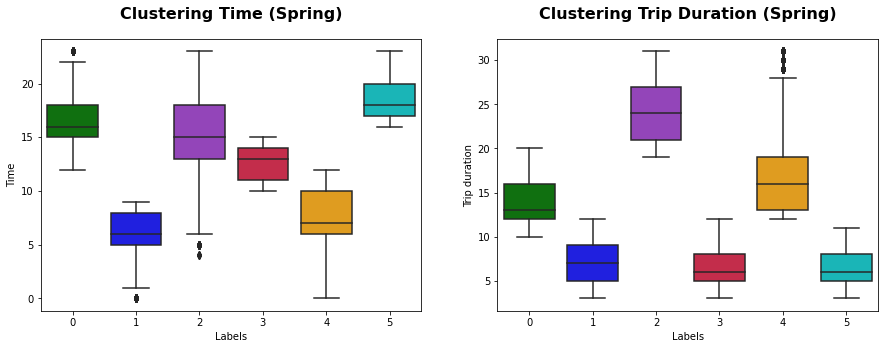

In [78]:
fig, axes = plt.subplots(1,2, sharex = True, figsize = (15,5))
ax1 = sns.boxplot(ax = axes[0], x="labels", y="time", data = df_bonn_spring, palette = ['green','blue','darkorchid','crimson','orange','darkturquoise'])
axes[0].set_title('Clustering Time (Spring)', fontsize=16, fontweight='bold',pad=20)
axes[0].set_xlabel('Label')
axes[0].set_ylabel('Time')
ax2 = sns.boxplot(ax = axes[1], x="labels", y="trip_duration", data= df_bonn_spring, palette = ['green','blue','darkorchid','crimson','orange','darkturquoise'])
axes[1].set_title('Clustering Trip Duration (Spring)', fontsize=16, fontweight='bold',pad=20)
axes[1].set_xlabel('Label')
axes[1].set_ylabel('Trip duration')

Text(0, 0.5, 'Trip duration')

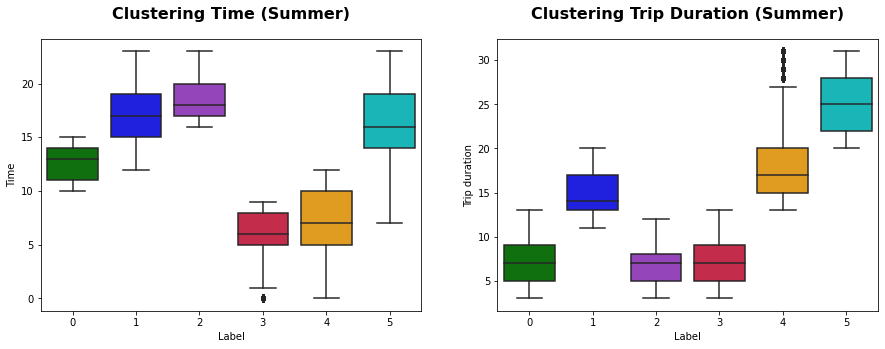

In [79]:
fig, axes = plt.subplots(1,2, sharex = True, figsize = (15,5))
ax1 = sns.boxplot(ax = axes[0], x="labels", y="time", data = df_bonn_summer, palette = ['green','blue','darkorchid','crimson','orange','darkturquoise'])
axes[0].set_title('Clustering Time (Summer)', fontsize=16, fontweight='bold',pad=20)
axes[0].set_xlabel('Label')
axes[0].set_ylabel('Time')
ax2 = sns.boxplot(ax = axes[1], x="labels", y="trip_duration", data= df_bonn_summer, palette = ['green','blue','darkorchid','crimson','orange','darkturquoise'])
axes[1].set_title('Clustering Trip Duration (Summer)', fontsize=16, fontweight='bold',pad=20)
axes[1].set_xlabel('Label')
axes[1].set_ylabel('Trip duration')

### Essen - Complete / non seasonal

At first we have to extract trip's daytimes and tripdurations

In [23]:
df_essen_clustering = pd.DataFrame(columns = ['time', 'trip_duration'])
df_essen_clustering['time'] = df_essen['timestamp'].dt.hour
df_essen_clustering['trip_duration'] = df_essen['trip_duration']
df_essen_clustering['trip_duration'] = df_essen_clustering['trip_duration'] / np.timedelta64(1, 'm')

#Normalize Data
mms_essen = StandardScaler()
mms_essen.fit(df_essen_clustering)
df_essen_normalized =  mms_essen.transform(df_essen_clustering)

Now the number of clusters has to be determined

[Text(0.5, 0, 'K'), Text(0, 0.5, 'Inertia')]

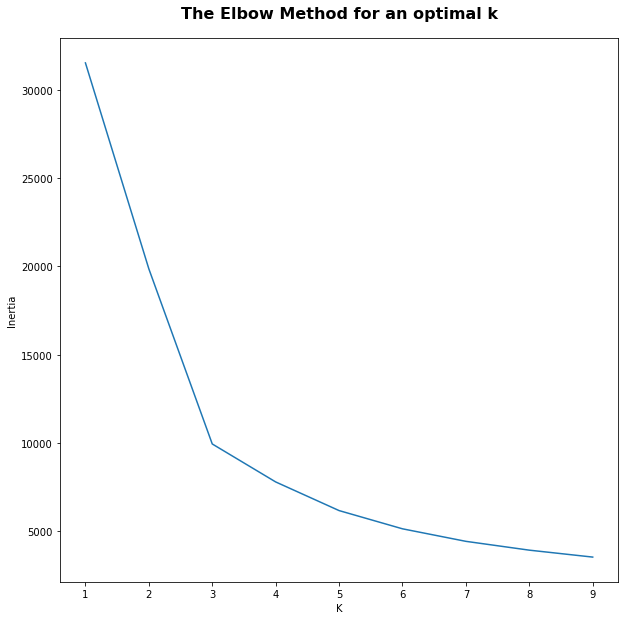

In [53]:
distortions_essen = []
K = range(1,10)

for k in K:
    kmeansModel_essen = KMeans(n_clusters=k, init='k-means++')
    kmeansModel_essen.fit(df_essen_normalized)
    distortions_essen.append(kmeansModel_essen.inertia_)
    

fig, axes = plt.subplots(1,1, sharex = True, figsize = (10,10))   
g =sns.lineplot(x = K, y = distortions_essen, color = 'C0')
g.set_title('The Elbow Method for an optimal k', fontsize=16, fontweight='bold',pad=20)
g.set(xlabel ='K', ylabel='Inertia')

In [25]:
# Five Clusters should fit
kmeansModel_essen = KMeans(n_clusters = 5, init='k-means++')
kmeansModel_essen = kmeansModel_essen.fit(df_essen_normalized)

df_essen_clustering['labels'] = kmeansModel_essen.labels_

Text(0, 0.5, 'Time (h)')

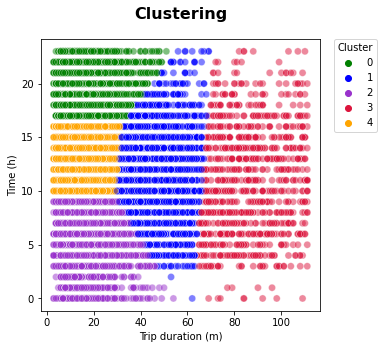

In [80]:
fig, axes = plt.subplots(1,1, sharex = True, figsize = (5,5))
figure3 = sns.scatterplot(data = df_essen_clustering, x = "trip_duration", y = "time", hue='labels', s=50, alpha=0.5, palette = ['green','blue','darkorchid','crimson','orange'])
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., title='Cluster')
figure3.set_title('Clustering', fontsize=16, fontweight='bold',pad=20)
figure3.set_xlabel('Trip duration (m)')
figure3.set_ylabel('Time (h)')

Text(0, 0.5, 'Trip duration')

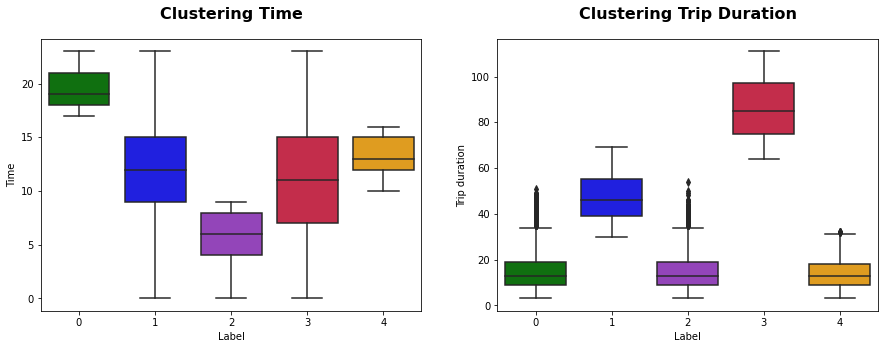

In [81]:
fig, axes = plt.subplots(1,2, sharex = True, figsize = (15,5))
ax1 = sns.boxplot(ax = axes[0], x="labels", y="time", data = df_essen_clustering, palette = ['green','blue','darkorchid','crimson','orange'])
axes[0].set_title('Clustering Time', fontsize=16, fontweight='bold',pad=20)
axes[0].set_xlabel('Label')
axes[0].set_ylabel('Time')
ax2 = sns.boxplot(ax = axes[1], x="labels", y="trip_duration", data= df_essen_clustering, palette = ['green','blue','darkorchid','crimson','orange'])
axes[1].set_title('Clustering Trip Duration', fontsize=16, fontweight='bold',pad=20)
axes[1].set_xlabel('Label')
axes[1].set_ylabel('Trip duration')

### Essen - Seasonal

In [28]:
df_essen_seasonal_clustering = pd.DataFrame(columns = ['time', 'trip_duration','season'])
df_essen_seasonal_clustering['time'] = df_essen['timestamp'].dt.hour
df_essen_seasonal_clustering['trip_duration'] = df_essen['trip_duration']
df_essen_seasonal_clustering['trip_duration'] = df_essen_seasonal_clustering['trip_duration'] / np.timedelta64(1, 'm')
df_essen_seasonal_clustering['season'] = df_essen['season']

df_essen_winter = pd.DataFrame(columns = ['time', 'trip_duration'])
df_essen_winter['time'] = df_essen['timestamp'].dt.hour[(df_essen.timestamp.dt.date < date(2019, 3, 1))]
df_essen_winter['trip_duration'] = df_essen['trip_duration'][(df_essen.timestamp.dt.date < date(2019, 3, 1))]
df_essen_winter['trip_duration'] = df_essen_winter['trip_duration'] / np.timedelta64(1, 'm')

df_essen_spring = pd.DataFrame(columns = ['time', 'trip_duration'])
df_essen_spring['time'] = df_essen['timestamp'].dt.hour[(df_essen.timestamp.dt.date >= date(2019, 3, 1)) & (df_essen.timestamp.dt.date < date(2019, 6, 1))]
df_essen_spring['trip_duration'] = df_essen['trip_duration'][(df_essen.timestamp.dt.date >= date(2019, 3, 1)) & (df_essen.timestamp.dt.date < date(2019, 6, 1))]
df_essen_spring['trip_duration'] = df_essen_spring['trip_duration'] / np.timedelta64(1, 'm')

df_essen_summer = pd.DataFrame(columns = ['time', 'trip_duration'])
df_essen_summer['time'] = df_essen['timestamp'].dt.hour[(df_essen.timestamp.dt.date >= date(2019, 6, 1))]
df_essen_summer['trip_duration'] = df_essen['trip_duration'][(df_essen.timestamp.dt.date >= date(2019, 6, 1))]
df_essen_summer['trip_duration'] = df_essen_summer['trip_duration'] / np.timedelta64(1, 'm')

#Normalize Data
standard_essen_winter = StandardScaler()
standard_essen_spring = StandardScaler()
standard_essen_summer = StandardScaler()
standard_essen_winter.fit(df_essen_winter)
standard_essen_spring.fit(df_essen_spring)
standard_essen_summer.fit(df_essen_summer)
df_essen_winter_normalized = standard_essen_winter.transform(df_essen_winter)
df_essen_spring_normalized = standard_essen_spring.transform(df_essen_spring)
df_essen_summer_normalized = standard_essen_summer.transform(df_essen_summer)

Text(0, 0.5, 'Inertia')

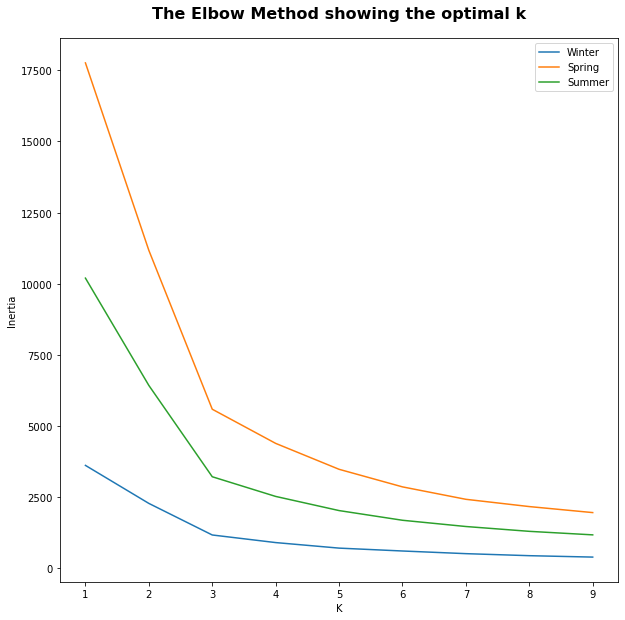

In [83]:
distortions_essen_winter = []
distortions_essen_spring = []
distortions_essen_summer = []
K = range(1,10)

for k in K:
    kmeansModel_essen_winter = KMeans(n_clusters=k, init='k-means++')
    kmeansModel_essen_spring = KMeans(n_clusters=k, init='k-means++')
    kmeansModel_essen_summer = KMeans(n_clusters=k, init='k-means++')
    
    kmeansModel_essen_winter.fit(df_essen_winter_normalized)
    kmeansModel_essen_spring.fit(df_essen_spring_normalized)
    kmeansModel_essen_summer.fit(df_essen_summer_normalized)
    
    
    distortions_essen_winter.append(kmeansModel_essen_winter.inertia_)
    distortions_essen_spring.append(kmeansModel_essen_spring.inertia_)
    distortions_essen_summer.append(kmeansModel_essen_summer.inertia_)

    
fig, axes = plt.subplots(1,1, sharex = True, figsize = (10,10))   
figure4 = sns.lineplot(x = K, y = distortions_essen_winter, legend='brief', label='Winter')
sns.lineplot(x = K, y = distortions_essen_spring, legend='brief', label='Spring')
sns.lineplot(x = K, y = distortions_essen_summer, legend='brief', label='Summer')
figure4.set_title('The Elbow Method showing the optimal k', fontsize=16, fontweight='bold',pad=20)
plt.xlabel('K')
plt.ylabel('Inertia')

In [30]:
# Five Clusters should fit
kmeansModel_essen_winter = KMeans(n_clusters = 5, init='k-means++')
kmeansModel_essen_spring = KMeans(n_clusters = 5, init='k-means++')
kmeansModel_essen_summer = KMeans(n_clusters = 5, init='k-means++')

kmeansModel_essen_winter = kmeansModel_essen_winter.fit(df_essen_winter_normalized)
kmeansModel_essen_spring = kmeansModel_essen_spring.fit(df_essen_spring_normalized)
kmeansModel_essen_summer = kmeansModel_essen_summer.fit(df_essen_summer_normalized)


df_essen_winter['labels'] = kmeansModel_essen_winter.labels_
df_essen_spring['labels'] = kmeansModel_essen_spring.labels_
df_essen_summer['labels'] = kmeansModel_essen_summer.labels_

Text(0, 0.5, 'Time')

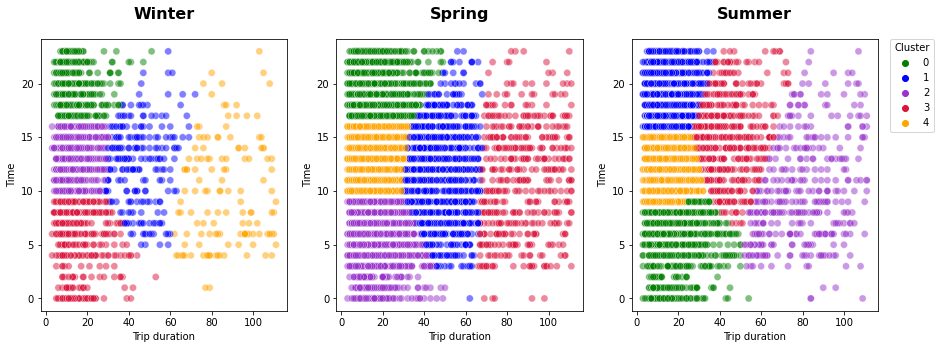

In [84]:
fig, axes = plt.subplots(1,3, sharex = True, figsize = (15,5))
sns.scatterplot(ax = axes[0], data = df_essen_winter, x = "trip_duration", y = "time", hue='labels', s=50, alpha=0.5, palette = ['green','blue','darkorchid','crimson','orange'])
axes[0].set_title('Winter', fontsize=16, fontweight='bold',pad=20)
axes[0].get_legend().remove()
axes[0].set_xlabel('Trip duration')
axes[0].set_ylabel('Time')
sns.scatterplot(ax = axes[1], data = df_essen_spring, x = "trip_duration", y = "time", hue='labels', s=50, alpha=0.5, palette = ['green','blue','darkorchid','crimson','orange'])
axes[1].set_title('Spring', fontsize=16, fontweight='bold',pad=20)
axes[1].get_legend().remove()
axes[1].set_xlabel('Trip duration')
axes[1].set_ylabel('Time')
sns.scatterplot(ax = axes[2], data = df_essen_summer, x = "trip_duration", y = "time", hue='labels', s=50, alpha=0.5, palette = ['green','blue','darkorchid','crimson','orange'])
axes[2].set_title('Summer', fontsize=16, fontweight='bold',pad=20)
axes[2].legend(bbox_to_anchor=(1.05,1),loc=2,borderaxespad=0.,title='Cluster')
axes[2].set_xlabel('Trip duration')
axes[2].set_ylabel('Time')

Text(0, 0.5, 'Trip duration')

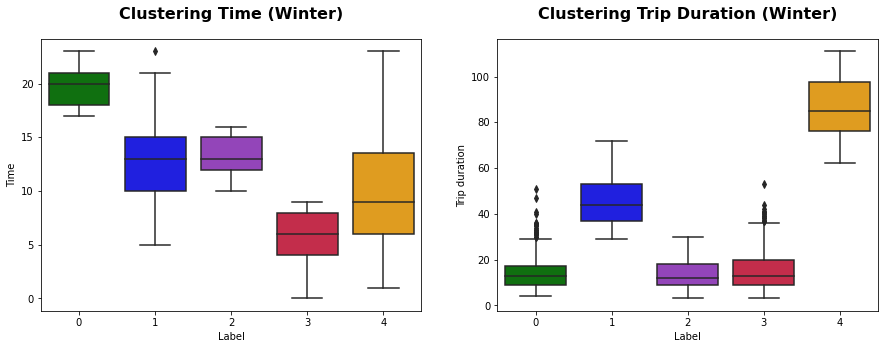

In [85]:
fig, axes = plt.subplots(1,2, sharex = True, figsize = (15,5))
ax1 = sns.boxplot(ax = axes[0], x="labels", y="time", data = df_essen_winter, palette = ['green','blue','darkorchid','crimson','orange'])
axes[0].set_title('Clustering Time (Winter)', fontsize=16, fontweight='bold',pad=20)
axes[0].set_xlabel('Label')
axes[0].set_ylabel('Time')
ax2 = sns.boxplot(ax = axes[1], x="labels", y="trip_duration", data= df_essen_winter, palette = ['green','blue','darkorchid','crimson','orange'])
axes[1].set_title('Clustering Trip Duration (Winter)', fontsize=16, fontweight='bold',pad=20)
axes[1].set_xlabel('Label')
axes[1].set_ylabel('Trip duration')

Text(0, 0.5, 'Trip duration')

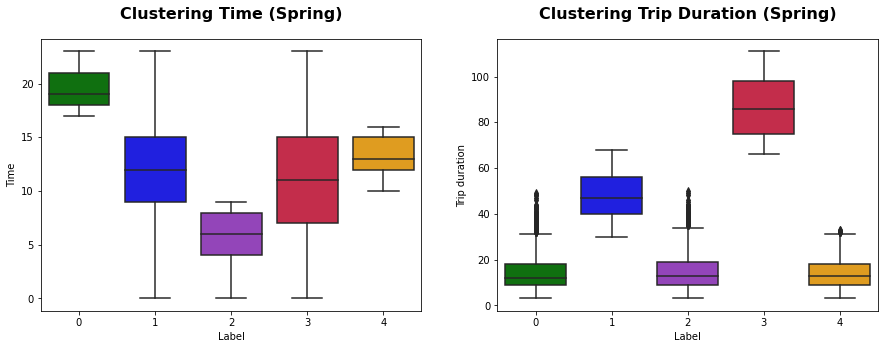

In [88]:
fig, axes = plt.subplots(1,2, sharex = True, figsize = (15,5))
ax1 = sns.boxplot(ax = axes[0], x="labels", y="time", data = df_essen_spring, palette = ['green','blue','darkorchid','crimson','orange'])
axes[0].set_title('Clustering Time (Spring)', fontsize=16, fontweight='bold',pad=20)
axes[0].set_xlabel('Label')
axes[0].set_ylabel('Time')
ax2 = sns.boxplot(ax = axes[1], x="labels", y="trip_duration", data= df_essen_spring, palette = ['green','blue','darkorchid','crimson','orange'])
axes[1].set_title('Clustering Trip Duration (Spring)', fontsize=16, fontweight='bold',pad=20)
axes[1].set_xlabel('Label')
axes[1].set_ylabel('Trip duration')

Text(0, 0.5, 'Trip duration')

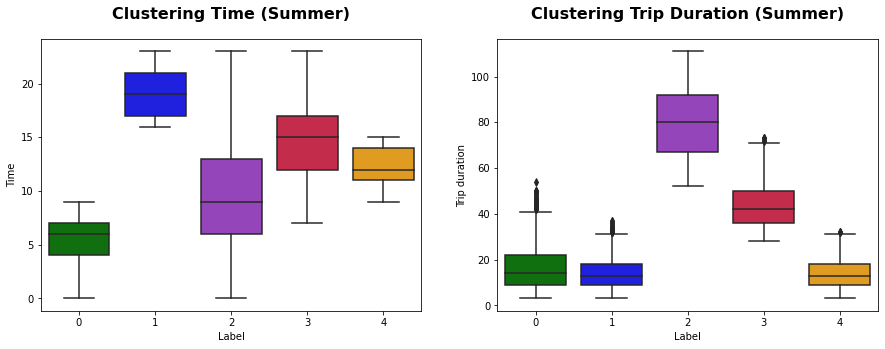

In [89]:
fig, axes = plt.subplots(1,2, sharex = True, figsize = (15,5))
ax1 = sns.boxplot(ax = axes[0], x="labels", y="time", data = df_essen_summer, palette = ['green','blue','darkorchid','crimson','orange'])
axes[0].set_title('Clustering Time (Summer)', fontsize=16, fontweight='bold',pad=20)
axes[0].set_xlabel('Label')
axes[0].set_ylabel('Time')
ax2 = sns.boxplot(ax = axes[1], x="labels", y="trip_duration", data= df_essen_summer, palette = ['green','blue','darkorchid','crimson','orange'])
axes[1].set_title('Clustering Trip Duration (Summer)', fontsize=16, fontweight='bold',pad=20)
axes[1].set_xlabel('Label')
axes[1].set_ylabel('Trip duration')

## Time/ Tripdistance

### Bonn - Seasonal

In [35]:
# Combine longitude/latitude coordinate columns: orig
df_bonn["distance (km)"] = df_bonn.apply(lambda row: haversine(row["orig"], row["dest"]), axis=1)
df_bonn.head()

,day,time,b_number,city,trip_duration,timestamp,weekday,hour,season,orig,dest,distance (km)
0,2019-02-01,00:03:00,44894,bonn,0 days 00:07:00,2019-02-01 00:03:00,4,0,0,"[50.7366, 7.1009]","[50.739, 7.093]",0.616674
1,2019-02-01,00:12:00,44973,bonn,0 days 00:20:00,2019-02-01 00:12:00,4,0,0,"[50.7364, 7.0927]","[50.732, 7.1004]",0.730093
2,2019-02-01,00:37:00,44802,bonn,0 days 00:06:00,2019-02-01 00:37:00,4,0,0,"[50.7372, 7.0911]","[50.7336, 7.095]",0.485359
3,2019-02-01,00:38:00,44717,bonn,0 days 00:07:00,2019-02-01 00:38:00,4,0,0,"[50.7476, 7.0826]","[50.7543, 7.0715]",1.079285
4,2019-02-01,00:44:00,44639,bonn,0 days 00:10:00,2019-02-01 00:44:00,4,0,0,"[50.7392, 7.0906]","[50.7525, 7.0712]",2.012538


In [36]:
df_bonn_distance_clustering = pd.DataFrame(columns = ['time', 'distance (km)','season'])
df_bonn_distance_clustering['time'] = df_bonn['timestamp'].dt.hour
df_bonn_distance_clustering['distance (km)'] = df_bonn['distance (km)']
df_bonn_distance_clustering['season'] = df_bonn['season']

df_bonn_distance_winter = pd.DataFrame(columns = ['time', 'distance (km)'])
df_bonn_distance_winter['time'] = df_bonn['timestamp'].dt.hour[(df_bonn.timestamp.dt.date < date(2019, 3, 1))]
df_bonn_distance_winter['distance (km)'] = df_bonn['distance (km)'][(df_bonn.timestamp.dt.date < date(2019, 3, 1))]

df_bonn_distance_spring = pd.DataFrame(columns = ['time', 'distance (km)'])
df_bonn_distance_spring['time'] = df_bonn['timestamp'].dt.hour[(df_bonn.timestamp.dt.date >= date(2019, 3, 1)) & (df_bonn.timestamp.dt.date < date(2019, 6, 1))]
df_bonn_distance_spring['distance (km)'] = df_bonn['distance (km)'][(df_bonn.timestamp.dt.date >= date(2019, 3, 1)) & (df_bonn.timestamp.dt.date < date(2019, 6, 1))]

df_bonn_distance_summer = pd.DataFrame(columns = ['time', 'distance (km)'])
df_bonn_distance_summer['time'] = df_bonn['timestamp'].dt.hour[(df_bonn.timestamp.dt.date >= date(2019, 6, 1))]
df_bonn_distance_summer['distance (km)'] = df_bonn['distance (km)'][(df_bonn.timestamp.dt.date >= date(2019, 6, 1))]

#Normalize Data
standard_bonn_distance_winter = StandardScaler()
standard_bonn_distance_spring = StandardScaler()
standard_bonn_distance_summer = StandardScaler()
standard_bonn_distance_winter.fit(df_bonn_distance_winter)
standard_bonn_distance_spring.fit(df_bonn_distance_spring)
standard_bonn_distance_summer.fit(df_bonn_distance_summer)
df_bonn_distance_winter_normalized = standard_bonn_distance_winter.transform(df_bonn_distance_winter)
df_bonn_distance_spring_normalized = standard_bonn_distance_spring.transform(df_bonn_distance_spring)
df_bonn_distance_summer_normalized = standard_bonn_distance_summer.transform(df_bonn_distance_summer)


Text(0, 0.5, 'Inertia')

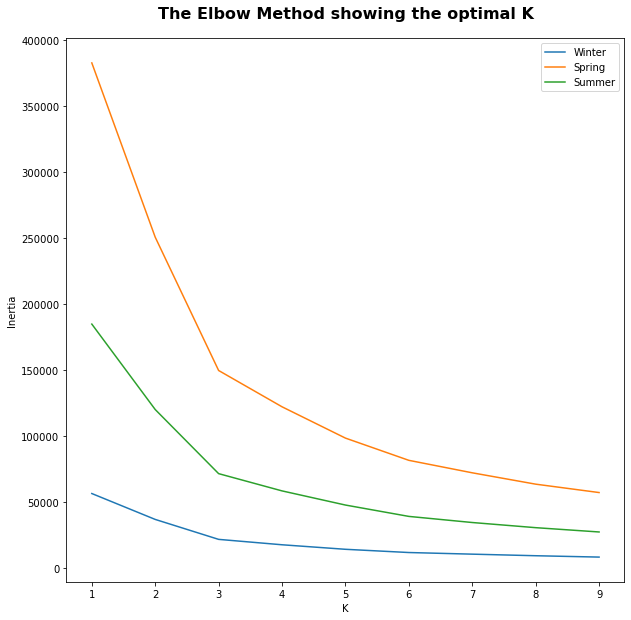

In [90]:
distortions_bonn_distance_winter = []
distortions_bonn_distance_spring = []
distortions_bonn_distance_summer = []
K = range(1,10)

for k in K:
    kmeansModel_bonn_distance_winter = KMeans(n_clusters=k, init='k-means++')
    kmeansModel_bonn_distance_spring = KMeans(n_clusters=k, init='k-means++')
    kmeansModel_bonn_distance_summer = KMeans(n_clusters=k, init='k-means++')
    
    kmeansModel_bonn_distance_winter.fit(df_bonn_distance_winter_normalized)
    kmeansModel_bonn_distance_spring.fit(df_bonn_distance_spring_normalized)
    kmeansModel_bonn_distance_summer.fit(df_bonn_distance_summer_normalized)
    
    
    distortions_bonn_distance_winter.append(kmeansModel_bonn_distance_winter.inertia_)
    distortions_bonn_distance_spring.append(kmeansModel_bonn_distance_spring.inertia_)
    distortions_bonn_distance_summer.append(kmeansModel_bonn_distance_summer.inertia_)
    

fig, axes = plt.subplots(1,1, sharex = True, figsize = (10,10))   
figure5 = sns.lineplot(x = K, y = distortions_bonn_distance_winter, legend='brief', label='Winter')
sns.lineplot(x = K, y = distortions_bonn_distance_spring, legend='brief', label='Spring')
sns.lineplot(x = K, y = distortions_bonn_distance_summer, legend='brief', label='Summer')
figure5.set_title('The Elbow Method showing the optimal K', fontsize=16, fontweight='bold',pad=20 )
plt.xlabel('K')
plt.ylabel('Inertia')

In [38]:
# Six Clusters should fit
kmeansModel_bonn_distance_winter = KMeans(n_clusters = 6, init='k-means++')
kmeansModel_bonn_distance_spring = KMeans(n_clusters = 6, init='k-means++')
kmeansModel_bonn_distance_summer = KMeans(n_clusters = 6, init='k-means++')

kmeansModel_bonn_distance_winter = kmeansModel_bonn_distance_winter.fit(df_bonn_distance_winter_normalized)
kmeansModel_bonn_distance_spring = kmeansModel_bonn_distance_spring.fit(df_bonn_distance_spring_normalized)
kmeansModel_bonn_distance_summer = kmeansModel_bonn_distance_summer.fit(df_bonn_distance_summer_normalized)


df_bonn_distance_winter['labels'] = kmeansModel_bonn_distance_winter.labels_
df_bonn_distance_spring['labels'] = kmeansModel_bonn_distance_spring.labels_
df_bonn_distance_summer['labels'] = kmeansModel_bonn_distance_summer.labels_

Text(0, 0.5, 'time')

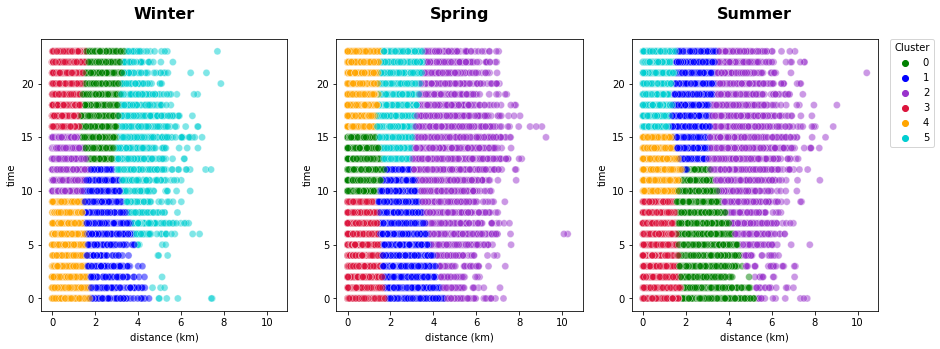

In [92]:
fig, axes = plt.subplots(1,3, sharex = True, figsize = (15,5))
sns.scatterplot(ax = axes[0], data = df_bonn_distance_winter, x = "distance (km)", y = "time", hue='labels', s=50, alpha=0.5, palette = ['green','blue','darkorchid','crimson','orange','darkturquoise'])
axes[0].set_title('Winter', fontsize=16, fontweight='bold',pad=20)
axes[0].get_legend().remove()
axes[0].set_xlabel('distance (km)')
axes[0].set_ylabel('time')
sns.scatterplot(ax = axes[1], data = df_bonn_distance_spring, x = "distance (km)", y = "time", hue='labels', s=50, alpha=0.5, palette = ['green','blue','darkorchid','crimson','orange','darkturquoise'])
axes[1].set_title('Spring', fontsize=16, fontweight='bold',pad=20)
axes[1].get_legend().remove()
axes[1].set_xlabel('distance (km)')
axes[1].set_ylabel('time')
sns.scatterplot(ax = axes[2], data = df_bonn_distance_summer, x = "distance (km)", y = "time", hue='labels', s=50, alpha=0.5, palette = ['green','blue','darkorchid','crimson','orange','darkturquoise'])
axes[2].set_title('Summer', fontsize=16, fontweight='bold',pad=20)
axes[2].legend(bbox_to_anchor=(1.05,1),loc=2,borderaxespad=0.,title='Cluster')
axes[2].set_xlabel('distance (km)')
axes[2].set_ylabel('time')

Text(0, 0.5, 'Distance (km)')

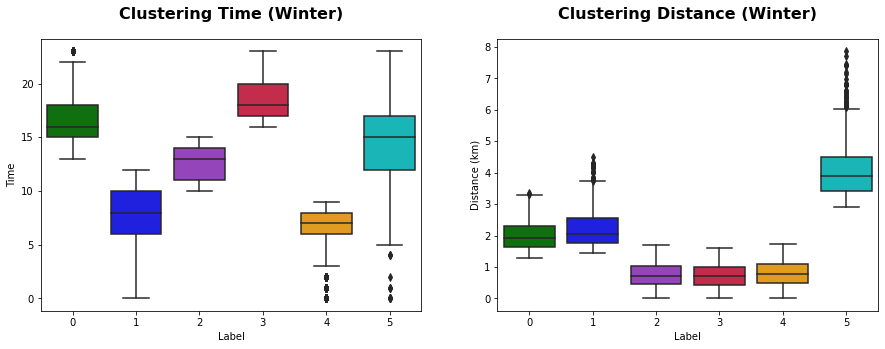

In [96]:
fig, axes = plt.subplots(1,2, sharex = True, figsize = (15,5))
ax1 = sns.boxplot(ax = axes[0], x="labels", y="time", data = df_bonn_distance_winter, palette = ['green','blue','darkorchid','crimson','orange','darkturquoise'])
axes[0].set_title('Clustering Time (Winter)', fontsize=16, fontweight='bold',pad=20)
axes[0].set_xlabel('Label')
axes[0].set_ylabel('Time')
ax2 = sns.boxplot(ax = axes[1], x="labels", y="distance (km)", data= df_bonn_distance_winter, palette = ['green','blue','darkorchid','crimson','orange','darkturquoise'])
axes[1].set_title('Clustering Distance (Winter)', fontsize=16, fontweight='bold',pad=20)
axes[1].set_xlabel('Label')
axes[1].set_ylabel('Distance (km)')

Text(0, 0.5, 'Distance (km)')

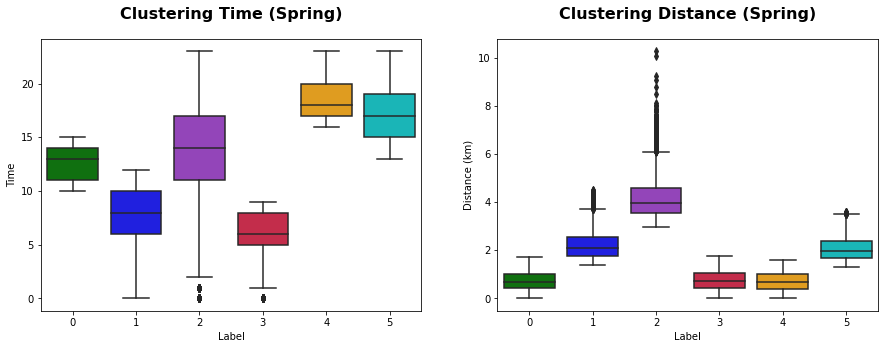

In [97]:
fig, axes = plt.subplots(1,2, sharex = True, figsize = (15,5))
ax1 = sns.boxplot(ax = axes[0], x="labels", y="time", data = df_bonn_distance_spring, palette = ['green','blue','darkorchid','crimson','orange','darkturquoise'])
axes[0].set_title('Clustering Time (Spring)', fontsize=16, fontweight='bold',pad=20)
axes[0].set_xlabel('Label')
axes[0].set_ylabel('Time')
ax2 = sns.boxplot(ax = axes[1], x="labels", y="distance (km)", data= df_bonn_distance_spring, palette = ['green','blue','darkorchid','crimson','orange','darkturquoise'])
axes[1].set_title('Clustering Distance (Spring)', fontsize=16, fontweight='bold',pad=20)
axes[1].set_xlabel('Label')
axes[1].set_ylabel('Distance (km)')

Text(0, 0.5, 'Distance (km)')

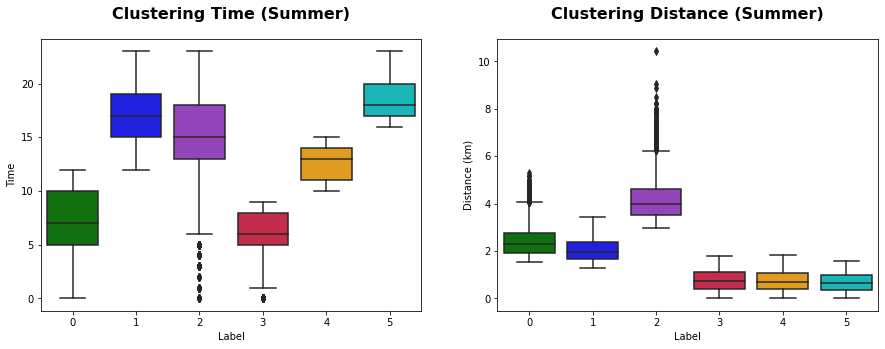

In [98]:
fig, axes = plt.subplots(1,2, sharex = True, figsize = (15,5))
ax1 = sns.boxplot(ax = axes[0], x="labels", y="time", data = df_bonn_distance_summer, palette = ['green','blue','darkorchid','crimson','orange','darkturquoise'])
axes[0].set_title('Clustering Time (Summer)', fontsize=16, fontweight='bold',pad=20)
axes[0].set_xlabel('Label')
axes[0].set_ylabel('Time')
ax2 = sns.boxplot(ax = axes[1], x="labels", y="distance (km)", data= df_bonn_distance_summer, palette = ['green','blue','darkorchid','crimson','orange','darkturquoise'])
axes[1].set_title('Clustering Distance (Summer)', fontsize=16, fontweight='bold',pad=20)
axes[1].set_xlabel('Label')
axes[1].set_ylabel('Distance (km)')

### Essen - Seasonal

In [43]:
# Combine longitude/latitude coordinate columns: orig
df_essen["distance (km)"] = df_essen.apply(lambda row: haversine(row["orig"], row["dest"]), axis=1)
df_essen.head()

,day,time,b_number,city,trip_duration,timestamp,weekday,hour,season,orig,dest,distance (km)
0,2019-02-01,00:05:00,50182,essen,0 days 00:18:00,2019-02-01 00:05:00,4,0,0,"[51.443, 7.0163]","[51.4439, 6.9778]",2.670173
1,2019-02-01,00:46:00,53528,essen,0 days 00:08:00,2019-02-01 00:46:00,4,0,0,"[51.434, 7.0036]","[51.4267, 7.0028]",0.813617
2,2019-02-01,04:50:00,52115,essen,0 days 00:09:00,2019-02-01 04:50:00,4,4,0,"[51.4618, 7.0078]","[51.4522, 7.0146]",1.166822
3,2019-02-01,05:41:00,52196,essen,0 days 00:08:00,2019-02-01 05:41:00,4,5,0,"[51.4382, 7.0057]","[51.4328, 6.9888]",1.316402
4,2019-02-01,06:16:00,53700,essen,0 days 00:10:00,2019-02-01 06:16:00,4,6,0,"[51.4544, 7.0113]","[51.4581, 7.0003]",0.866113


In [44]:
df_essen_distance_clustering = pd.DataFrame(columns = ['time', 'distance (km)','season'])
df_essen_distance_clustering['time'] = df_essen['timestamp'].dt.hour
df_essen_distance_clustering['distance (km)'] = df_essen['distance (km)']
df_essen_distance_clustering['season'] = df_essen['season']

df_essen_distance_winter = pd.DataFrame(columns = ['time', 'distance (km)'])
df_essen_distance_winter['time'] = df_essen['timestamp'].dt.hour[(df_essen.timestamp.dt.date < date(2019, 3, 1))]
df_essen_distance_winter['distance (km)'] = df_essen['distance (km)'][(df_essen.timestamp.dt.date < date(2019, 3, 1))]

df_essen_distance_spring = pd.DataFrame(columns = ['time', 'distance (km)'])
df_essen_distance_spring['time'] = df_essen['timestamp'].dt.hour[(df_essen.timestamp.dt.date >= date(2019, 3, 1)) & (df_essen.timestamp.dt.date < date(2019, 6, 1))]
df_essen_distance_spring['distance (km)'] = df_essen['distance (km)'][(df_essen.timestamp.dt.date >= date(2019, 3, 1)) & (df_essen.timestamp.dt.date < date(2019, 6, 1))]

df_essen_distance_summer = pd.DataFrame(columns = ['time', 'distance (km)'])
df_essen_distance_summer['time'] = df_essen['timestamp'].dt.hour[(df_essen.timestamp.dt.date >= date(2019, 6, 1))]
df_essen_distance_summer['distance (km)'] = df_essen['distance (km)'][(df_essen.timestamp.dt.date >= date(2019, 6, 1))]

#Normalize Data
standard_essen_distance_winter = StandardScaler()
standard_essen_distance_spring = StandardScaler()
standard_essen_distance_summer = StandardScaler()
standard_essen_distance_winter.fit(df_essen_distance_winter)
standard_essen_distance_spring.fit(df_essen_distance_spring)
standard_essen_distance_summer.fit(df_essen_distance_summer)
df_essen_distance_winter_normalized = standard_essen_distance_winter.transform(df_essen_distance_winter)
df_essen_distance_spring_normalized = standard_essen_distance_spring.transform(df_essen_distance_spring)
df_essen_distance_summer_normalized = standard_essen_distance_summer.transform(df_essen_distance_summer)

Text(0, 0.5, 'Inertia')

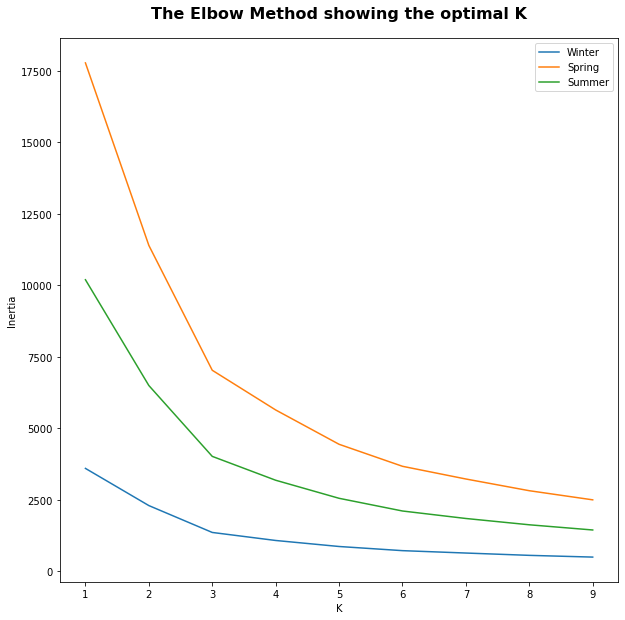

In [100]:
distortions_essen_distance_winter = []
distortions_essen_distance_spring = []
distortions_essen_distance_summer = []
K = range(1,10)

for k in K:
    kmeansModel_essen_distance_winter = KMeans(n_clusters=k, init='k-means++')
    kmeansModel_essen_distance_spring = KMeans(n_clusters=k, init='k-means++')
    kmeansModel_essen_distance_summer = KMeans(n_clusters=k, init='k-means++')
    
    kmeansModel_essen_distance_winter.fit(df_essen_distance_winter_normalized)
    kmeansModel_essen_distance_spring.fit(df_essen_distance_spring_normalized)
    kmeansModel_essen_distance_summer.fit(df_essen_distance_summer_normalized)
    
    
    distortions_essen_distance_winter.append(kmeansModel_essen_distance_winter.inertia_)
    distortions_essen_distance_spring.append(kmeansModel_essen_distance_spring.inertia_)
    distortions_essen_distance_summer.append(kmeansModel_essen_distance_summer.inertia_)
    

fig, axes = plt.subplots(1,1, sharex = True, figsize = (10,10))   
figure6 = sns.lineplot(x = K, y = distortions_essen_distance_winter, legend='brief', label='Winter')
sns.lineplot(x = K, y = distortions_essen_distance_spring, legend='brief', label='Spring')
sns.lineplot(x = K, y = distortions_essen_distance_summer, legend='brief', label='Summer')
figure6.set_title('The Elbow Method showing the optimal K', fontsize=16, fontweight='bold',pad=20)
plt.xlabel('K')
plt.ylabel('Inertia')

In [46]:
# Six Clusters should fit
kmeansModel_essen_distance_winter = KMeans(n_clusters = 6, init='k-means++')
kmeansModel_essen_distance_spring = KMeans(n_clusters = 6, init='k-means++')
kmeansModel_essen_distance_summer = KMeans(n_clusters = 6, init='k-means++')

kmeansModel_essen_distance_winter = kmeansModel_essen_distance_winter.fit(df_essen_distance_winter_normalized)
kmeansModel_essen_distance_spring = kmeansModel_essen_distance_spring.fit(df_essen_distance_spring_normalized)
kmeansModel_essen_distance_summer = kmeansModel_essen_distance_summer.fit(df_essen_distance_summer_normalized)


df_essen_distance_winter['labels'] = kmeansModel_essen_distance_winter.labels_
df_essen_distance_spring['labels'] = kmeansModel_essen_distance_spring.labels_
df_essen_distance_summer['labels'] = kmeansModel_essen_distance_summer.labels_

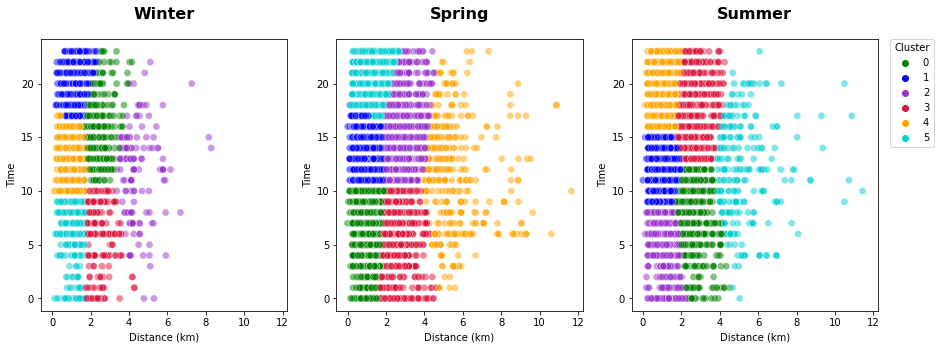

In [102]:
fig, axes = plt.subplots(1,3, sharex = True, figsize = (15,5))
sns.scatterplot(ax = axes[0], data = df_essen_distance_winter, x = "distance (km)", y = "time", hue='labels', s=50, alpha=0.5, palette = ['green','blue','darkorchid','crimson','orange','darkturquoise'])
axes[0].set_title('Winter', fontsize=16, fontweight='bold',pad=20)
axes[0].set_xlabel('Distance (km)')
axes[0].set_ylabel('Time')
axes[0].get_legend().remove()
sns.scatterplot(ax = axes[1], data = df_essen_distance_spring, x = "distance (km)", y = "time", hue='labels', s=50, alpha=0.5, palette = ['green','blue','darkorchid','crimson','orange','darkturquoise'])
axes[1].set_title('Spring', fontsize=16, fontweight='bold',pad=20)
axes[1].set_xlabel('Distance (km)')
axes[1].set_ylabel('Time')
axes[1].get_legend().remove()
sns.scatterplot(ax = axes[2], data = df_essen_distance_summer, x = "distance (km)", y = "time", hue='labels', s=50, alpha=0.5, palette = ['green','blue','darkorchid','crimson','orange','darkturquoise'])
axes[2].set_title('Summer', fontsize=16, fontweight='bold',pad=20)
axes[2].set_xlabel('Distance (km)')
axes[2].set_ylabel('Time')
axes[2].legend(bbox_to_anchor=(1.05,1),loc=2,borderaxespad=0.,title='Cluster')

Text(0, 0.5, 'Distance (km)')

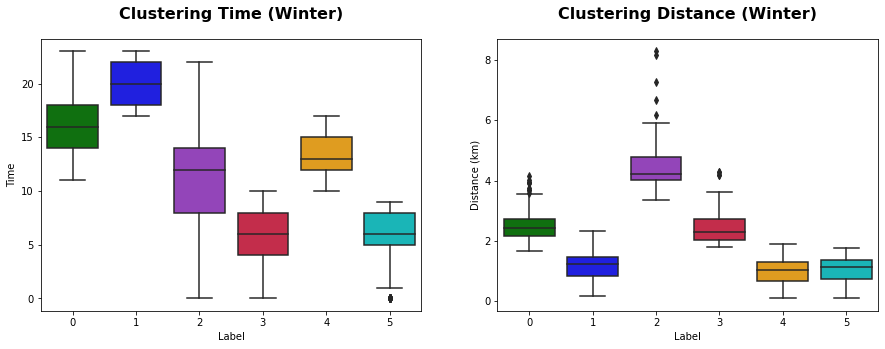

In [103]:
fig, axes = plt.subplots(1,2, sharex = True, figsize = (15,5))
ax1 = sns.boxplot(ax = axes[0], x="labels", y="time", data = df_essen_distance_winter, palette = ['green','blue','darkorchid','crimson','orange','darkturquoise'])
axes[0].set_title('Clustering Time (Winter)', fontsize=16, fontweight='bold',pad=20)
axes[0].set_xlabel('Label')
axes[0].set_ylabel('Time')
ax2 = sns.boxplot(ax = axes[1], x="labels", y="distance (km)", data= df_essen_distance_winter, palette = ['green','blue','darkorchid','crimson','orange','darkturquoise'])
axes[1].set_title('Clustering Distance (Winter)', fontsize=16, fontweight='bold',pad=20)
axes[1].set_xlabel('Label')
axes[1].set_ylabel('Distance (km)')

Text(0, 0.5, 'Distance (km)')

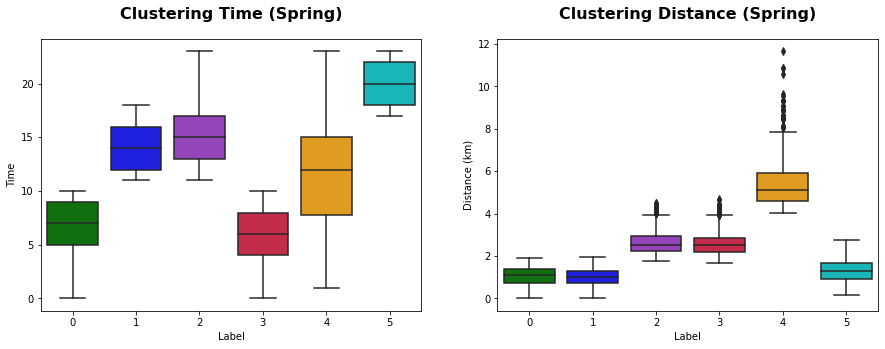

In [104]:
fig, axes = plt.subplots(1,2, sharex = True, figsize = (15,5))
ax1 = sns.boxplot(ax = axes[0], x="labels", y="time", data = df_essen_distance_spring, palette = ['green','blue','darkorchid','crimson','orange','darkturquoise'])
axes[0].set_title('Clustering Time (Spring)', fontsize=16, fontweight='bold',pad=20)
axes[0].set_xlabel('Label')
axes[0].set_ylabel('Time')
ax2 = sns.boxplot(ax = axes[1], x="labels", y="distance (km)", data= df_essen_distance_spring, palette = ['green','blue','darkorchid','crimson','orange','darkturquoise'])
axes[1].set_title('Clustering Distance (Spring)', fontsize=16, fontweight='bold',pad=20)
axes[1].set_xlabel('Label')
axes[1].set_ylabel('Distance (km)')

Text(0, 0.5, 'Distance (km)')

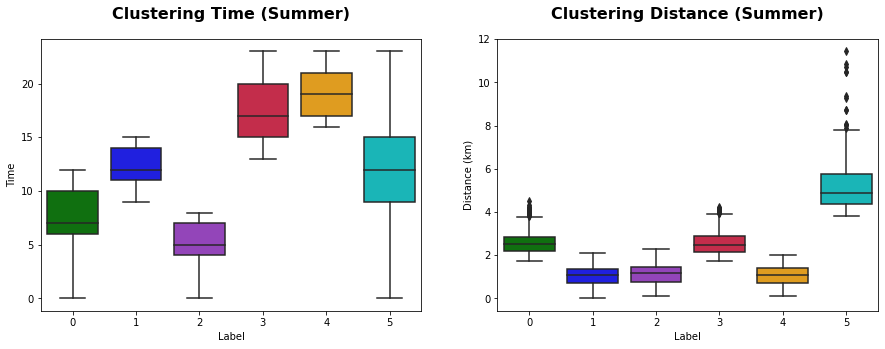

In [105]:
fig, axes = plt.subplots(1,2, sharex = True, figsize = (15,5))
ax1 = sns.boxplot(ax = axes[0], x="labels", y="time", data = df_essen_distance_summer, palette = ['green','blue','darkorchid','crimson','orange','darkturquoise'])
axes[0].set_title('Clustering Time (Summer)', fontsize=16, fontweight='bold',pad=20)
axes[0].set_xlabel('Label')
axes[0].set_ylabel('Time')
ax2 = sns.boxplot(ax = axes[1], x="labels", y="distance (km)", data= df_essen_distance_summer, palette = ['green','blue','darkorchid','crimson','orange','darkturquoise'])
axes[1].set_title('Clustering Distance (Summer)', fontsize=16, fontweight='bold',pad=20)
axes[1].set_xlabel('Label')
axes[1].set_ylabel('Distance (km)')